# Measurement of dipole trap parameters

Dipole trap potential can be written as $U(x,y,z)=U_0 \left(1 - \frac{1}{1+(z/z_0)^2} \exp\left(-\frac{2(x^2+y^2)}{w_0^2(1+(z/z_0)^2)}\right) \right)$. 

Dipole trap is characterized by the following parameters.

- $U_0$ - trap depth

- $w_0$ - beam radius

- $z_0$ - Rayleigh range

- $\lambda$ - wavelength of the laser that creates dipole trap


To measure atom temperature, model atom excitation, simulate quantum circuits and etc. it is crucial to know parameters of dipole trap. 

$\lambda$ is fixed by the laser choice, $z_0$ is determined as $z_0 = \frac{\pi w_0^2}{\lambda}$, so there are two parameters left - $U_0$ and $w_0$.

____

__1. Measurement of $U_0$.__

We can determine $U_0$ by measuring AC Stark shift created by dipole trap. 
AC Stark due to the dipole trap shift would be exactly equal to the trap depth. 


__2. Measurment of $w_0$.__

There are currently two well-known methods to measure beam radius: parametric heating and turning trap on and off scheme. 

Both of them require $U_0$ to be fixed, so we can feet experimental data by modelled curve that depends only on $w_0$.


__3. Real


## Trap frequencies

### Utilities

In [1]:
using PyPlot
using Statistics, Distributions, Random
using PhysicalConstants.CODATA2018: c_0, k_B, m_u
using Unitful
using LinearAlgebra
using SplitApplyCombine
using DataFrames
using CSV
using OrdinaryDiffEq
using DifferentialEquations
using ProgressMeter
using BenchmarkTools

__Constants__

In [168]:
c = ustrip(u"m/s", c_0);
kB = ustrip(u"J/K", k_B)
mu = ustrip(u"kg", m_u);

g = 9.81 * 1e-6;      #Acceleration due to gravity, μm/μs^2
m = 86.9091835;       #Rb87 mass
E0 = kB * 1e-6;       #Characteristic energy in μK
vconst = sqrt(E0/mu); #Useful constant for kinetic energy
r0 = 1e-6;            #Characteristic distance in m

In [169]:
println("Speed of light     : ", c)
println("Boltzmann constant : ", kB)
println("Atomic mass unit   : ", mu)

Speed of light     : 2.99792458e8
Boltzmann constant : 1.380649e-23
Atomic mass unit   : 1.6605390666e-27


__Utilities__

In [170]:
#Beam radius
function w(z, w0, z0)
    return w0 .* sqrt.(1.0 .+ (z ./z0) .^2)
end;



#Amplitude of gaussian beam with |E0|=1
function A(x, y, z, w0, z0)
    return (w0 ./ w(z, w0, z0)) .* exp.(- (x .^2 .+ y .^2) ./ (w(z, w0, z0) .^2))
end;



#Phase of gaussian beam
function Phase(x, y, z, w0, z0)
    k = 2.0 * z0 / w0^2;
    return exp.(-1.0im * k * z .* (0.5*(x .^2 .+ y .^ 2) ./ (z .^2  .+ z0 .^2)) + 1.0im * atan.(z ./ z0))
end;



#Complex amplitude of gaussian beam with |E0|=1
function E(x, y, z, w0, z0)
    return A(x,y,z,w0,z0) .* Phase(x,y,z,w0,z0)
end;

In [171]:
function Π(cord, trap_params)
    U0, w0, z0 = trap_params;
    x, y, z, vx, vy, vz = cord;
    return U0 .* (1.0 .- A(x, y, z, w0, z0) .^2);
end;


function Π_Harmonic(cord, trap_params)
    U0, w0, z0 = trap_params;
    x, y, z, vx, vy, vz = cord;
    
    r2 = x .^2 .+ y .^2;
    return U0 .* (2.0*r2 ./w0^2 + (z ./z0).^2);
end;


function K(cord, trap_params, m)
    U0, w0, z0 = trap_params;
    x, y, z, vx, vy, vz = cord;
    return m/vconst^2 *(vx .^2 + vy .^2 + vz .^2) / 2.0
end;


function H(cord, trap_params, m; harmonic=false)
    if harmonic
        return Π_Harmonic(cord, trap_params) .+ K(cord, trap_params, m)
    else
        return Π(cord, trap_params) .+ K(cord, trap_params, m)
    end;
end;

In [172]:
#function for samples visualisation
function samples_visualise(samples)
    x, y, z, vx, vy, vz = invert(samples);
    
    figure(figsize=(6,6))
    subplot(221)
    hist2D(x, z, bins=50, range=[[-1.0, 1.0], [-2.5, 2.5]],cmap="plasma", rasterized=true);
    xlabel("x, μm")
    ylabel("z, μm")
    title("Coordinate distribution");

    subplot(222)
    hist(x, bins=[-1.5:0.02:1.5;], density=true, alpha=0.5, label="x")
    hist(z, bins=[-2.0:0.1:2.0;], density=true, alpha=0.5, label="z")
    xlabel("μm")
    ylabel("pdf")
    title("Coordinate distribution");
    legend()

    subplot(223)
    hist2D(vx, vz, bins=50, range=[[-0.3, 0.3], [-0.3, 0.3]],cmap="plasma", rasterized=true);
    xlabel("\$ v_x \$, \$ \\mu m/ \\mu s \$")
    ylabel("\$ v_z \$, \$ \\mu m/ \\mu s \$")
    title("Velocity distribution");


    subplot(224)
    hist(vx, bins=[-0.3:0.01:0.3;], density=true, alpha=0.5, label="\$ v_x \$")
    hist(vz, bins=[-0.3:0.01:0.3;], density=true, alpha=0.5, label="\$ v_z \$")
    xlabel("\$ \\mu m/ \\mu s \$")
    ylabel("pdf")
    title("Velocity distribution");
    legend()

    tight_layout()
end;

### MCMC sampler

In [173]:
function prob_boltzmann(cord, trap_params, atom_params; harmonic=false)    
    m, T = atom_params;
    return exp.(- H(cord, trap_params, m; harmonic) ./ T)
end;



#N - number of samples
#skip - number of skipped samples at start
function boltzmann_samples(trap_params, atom_params, N; freq=10, skip=1000, harmonic=false)
    U0, w0, z0 = trap_params;
    m, T = atom_params;

    mean = zeros(6);
    vstep = vconst*sqrt(T/m);
    rstep = sqrt(T/U0)/2;
    cov = Diagonal(([w0*rstep, w0*rstep, z0*sqrt(2)*rstep, vstep, vstep, vstep]) .^ 2);
    d = MvNormal(mean, cov);
    
    samples = [[0.0, 0.0, 0.0, vstep/sqrt(3), vstep/sqrt(3), vstep/sqrt(3)]];
    u_acc = rand(Uniform(0.0, 1.0), N*freq + skip);
    acc_rate = 0;
    
    for i ∈ 1:N*freq + skip - 1
        cord_last = samples[end];
        cord_new = cord_last + rand(d);
        p_acc = prob_boltzmann(cord_new, trap_params, atom_params; harmonic)/prob_boltzmann(cord_last, trap_params, atom_params; harmonic);
        
        if p_acc > u_acc[i] && H(cord_new, trap_params, m; harmonic) < U0
            push!(samples, cord_new);
            acc_rate += 1; 
        else
            push!(samples, cord_last);
        end;
    end;
        
    return samples[1+skip:freq:end], acc_rate/(N*freq + skip)
end;

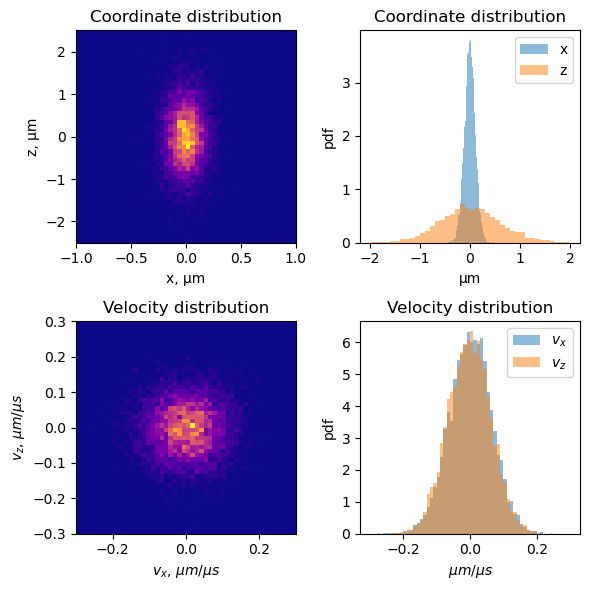

0.28378846153846154

In [521]:
samples, acc_rate = boltzmann_samples(trap_params, atom_params, 10000; freq=5, skip=2000);

samples_visualise(samples)
acc_rate

### Release&recapture

<img src="images/release_recap.png" 
     align="left" 
     width="800" />

Basic idea of release&recapture method is to trap atoms in dipole trap, release them for some variable time $\Delta t$ and measure the probability of atom to stay in the trap. If the atom is hot, it would leave the trap with high probability. The idea is to measure atoms' temperature by scanning $\Delta t$ and measuring survivial probability.

In [174]:
function is_zero(x)
    return x == 0
end;


function evolve(tspan, cord, atom_params, trap_params)
    xi, yi, zi, vxi, vyi, vzi = cord;
    m, T = atom_params;
    U0, w0, z0 = trap_params;
    
    x = xi .+ vxi * tspan;
    y = yi .+ vyi * tspan - g * tspan .^2;
    z = zi .+ vzi * tspan;
    
    kinetic = K(cord, trap_params, m);
    potential = U0 .* (1.0 .- A(x, y, z, w0, z0) .^2);
    recap = (kinetic .+ potential) .< U0;
    
    
    idx = findfirst(is_zero, recap);
    
    if idx != nothing
        recap[idx:end] .= 0;
    end;
    
    return recap
end; 

In [175]:
function release_recapture(tspan, trap_params, atom_params, N; freq=10, skip=1000)
    samples, acc_rate = boltzmann_samples(trap_params, atom_params, N; freq=freq, skip=skip);
    
    recapture = zeros(length(tspan));
    
    for i ∈ 1:N
        recapture += evolve(tspan, samples[i], atom_params, trap_params);
    end;
    
    return recapture ./ N, acc_rate
end;



function release_recapture_antitrapping(tspan, trap_params, atom_params, α, N; freq=10, skip=1000)
    samples, acc_rate = boltzmann_samples(trap_params, atom_params, N; freq=freq, skip=skip);
    
    recapture = zeros(length(tspan));
    
    for i ∈ 1:N
        recapture += evolve(tspan, samples[i], atom_params, trap_params);
    end;
    
    return recapture ./ N, acc_rate
end;

In [520]:
w0 = 1.0;
λ = 0.852;
z0 = π * w0^2/λ;

atom_params = [m, 43.0];
trap_params = [1000.0, w0, z0];

tspan = [0.0:0.1:120.0;];

In [177]:
z0

3.687315321114781

In [178]:
ωr = 2 * sqrt(1000/m)*vconst / w0;
ωz = sqrt(2) * sqrt(1000/m)*vconst /z0;

println(ωr *1e3 / (2π))
println(ωz *1e3 / (2π))

98.45423114530904
18.880309497997693


In [179]:
2*(sqrt(2) * sqrt(1000/m)*vconst / z0 * 1e3 / 2π)

37.76061899599539

Metropolis-Hastings sampler for atoms' coordinates and velocities in dipole trap. Sampling achieves Boltzman distribution for energies of atom in the dipole trap. 

In [181]:
recap1, acc_rate1 = release_recapture(tspan, trap_params, atom_params, 40000; freq=5, skip=10000);

recap2, acc_rate2 = release_recapture(tspan, trap_params, atom_params, 40000; freq=5, skip=10000);

recap3, acc_rate3 = release_recapture(tspan, trap_params, atom_params, 40000; freq=5, skip=10000);


println(acc_rate1)
println(acc_rate2)
println(acc_rate3)

0.28362857142857145
0.28332380952380953
0.2857904761904762


In [182]:
samples, acc_rate = boltzmann_samples(trap_params, atom_params, 10000; freq=5, skip=2000);

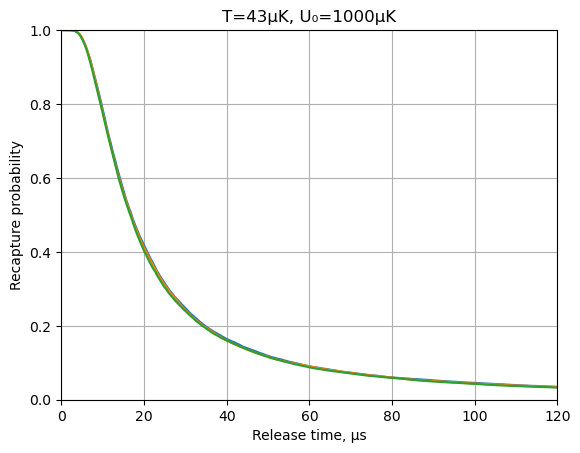

(0.0, 1.0)

In [183]:
plot(tspan, recap1)
plot(tspan, recap2)
plot(tspan, recap3)

xlabel("Release time, μs")
ylabel("Recapture probability")
title("T=43μK, U₀=1000μK")
grid()
xlim(0.0, 120.0)
ylim(0.0,1.0)

### Parametric heating of atom in dipole trap. Exact 3D case.

Dipole trap in harmonic approximation has two frequencies - radial and longitudinal. Cold enough atom oscillates with frequency $\omega_r$ along radial direction and with frequency $\omega_z$ along z-axis.


$\omega_r = \sqrt{\frac{4 U_0}{m}}\frac{1}{w_0}$ 

$\omega_z = \sqrt{\frac{2 U_0}{m}}\frac{1}{z_0}$ 

$z_0 = \frac{\pi w_0^2}{\lambda}$

By driving trap depth at $\sim 2\omega_r$ or $\sim 2\omega_z$ as $U(t) = U_0 (1 + \beta \sin(\omega t))$ we can excite parametric heating of atom. 

By measuring parametric resonance frequencies we can extract dipole trap parameters. 

#### Longitudinal parametric resonance

In [191]:
function f(x, y, z, params)
    U0, w0, z0 = params;
    return -4.0*U0*vconst^2/m*exp.(-2.0*(x .^ 2 + y .^ 2) ./ (w0^2*(1.0 .+ (z ./z0) .^ 2))) ./ (w0^2 * (1.0 .+ (z ./ z0) .^ 2) .^ 2)
end;



function atom_dynamics(du, u, params, t)
    U0, w0, z0, ω, β = params;
    x, y, z = u[1], u[2], u[3];
    vx, vy, vz = u[4], u[5], u[6];
    
    du[1], du[2], du[3] = vx, vy, vz;
    du[4] = (1.0 .+ β * sin.(ω * t)) * f(x, y, z, params) * x;
    du[5] = (1.0 .+ β * sin.(ω * t)) * f(x, y, z, params) * y;
    du[6] = (1.0 .+ β * sin.(ω * t)) * f(x, y, z, params) * (w0^2/(2.0 * z0^2) .- (x .^2 + y .^2)./(z .^2 .+ z0^2)) * z; 
end;

In [281]:
tspan = (0.0, 2e3);

ω_list = [0.0:0.0025:0.4;];
res_adaptive = zeros(length(ω_list));
step = 10;

@showprogress for j in 1:length(ω_list)
    @showprogress for i ∈ 1:step:length(samples)
        prob = ODEProblem(atom_dynamics, samples[i], tspan, [1000.0, 1.0, 3.7, ω_list[j], 0.4]);
        sol = solve(prob, dt=1.0);
        res_adaptive[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

res_adaptive = res_adaptive ./ (length(samples)/step);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 

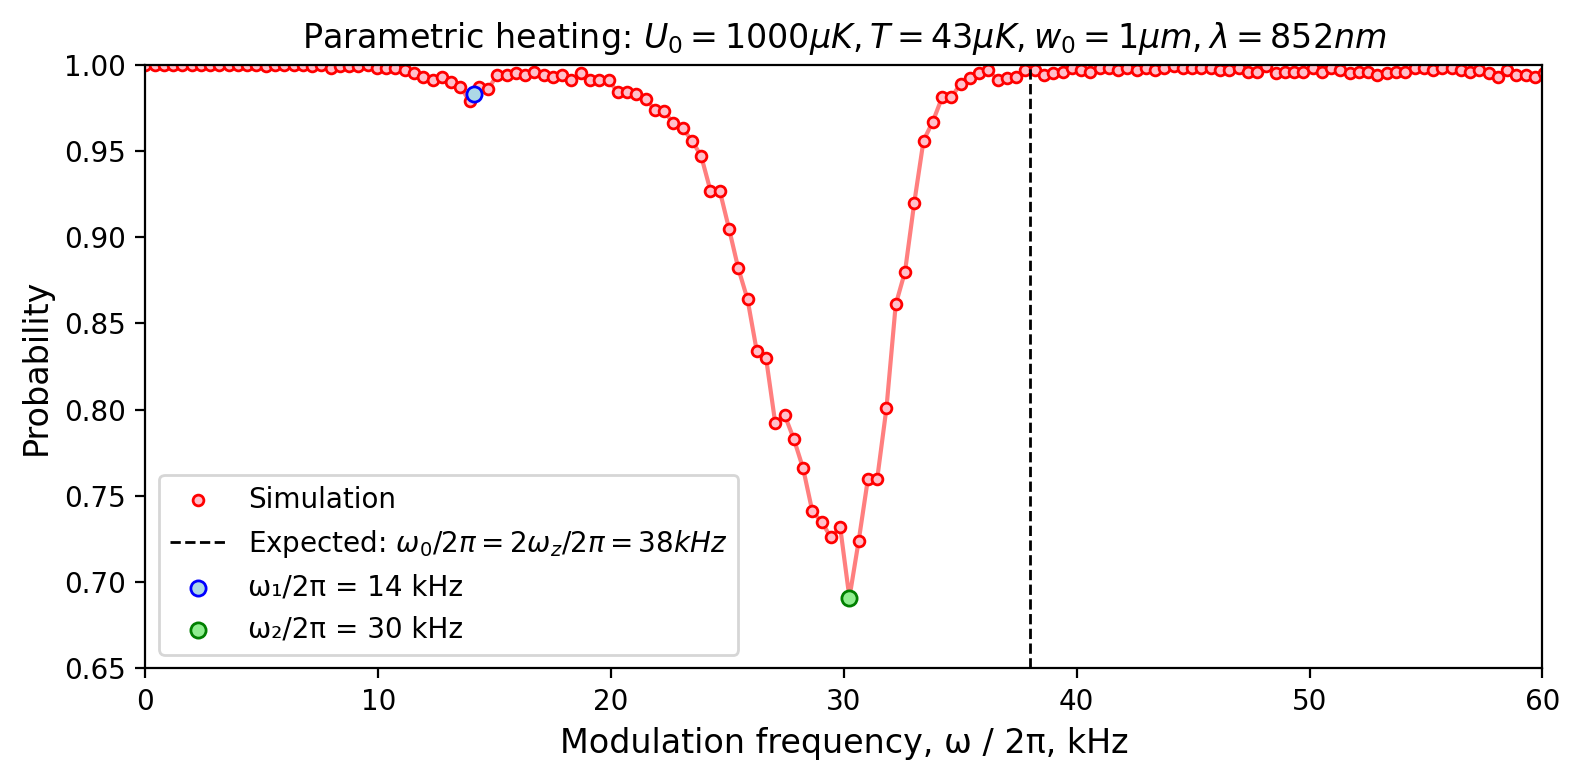

In [298]:
figure(figsize=(8,4), dpi=200)
idx = 40
plot(ω_list * 1e3 / 2π, res_adaptive, color="red", zorder=-2, alpha=0.5)
scatter(ω_list * 1e3 / 2π, res_adaptive, 
    color="pink", 
    s=15, 
    label="Simulation",
    edgecolor="red")
axvline(38.0, color="black", 
    linestyle="--", 
    linewidth=1, 
    label="Expected: \$ \\omega_0 / 2 \\pi =  2 \\omega_z / 2 \\pi = 38 kHz  \$")

idx1 = 36
scatter((ω_list[idx1] + ω_list[idx1+1])/2 * 1e3 / 2π, (res_adaptive[idx1]+res_adaptive[idx1+1])/2, 
    color="lightblue", 
    edgecolor="blue",
    s=30, label="ω₁/2π = 14 kHz", zorder=2)

idx2 = 77
scatter(ω_list[idx2] * 1e3 / 2π,res_adaptive[idx2], 
    color="lightgreen", 
    s=30, label="ω₂/2π = 30 kHz", zorder=2,
    edgecolor="green")

xlabel("Modulation frequency, ω / 2π, kHz", fontsize=12)
ylabel("Probability", fontsize=12)

xlim(0.0, 60.0)
ylim(0.65,1.0)

legend()
title("Parametric heating: \$ U_0 = 1000 \\mu K, T=43 \\mu K, w_0 = 1 \\mu m ,\\lambda = 852 nm \$")

tight_layout()
savefig("data/parametric_test_fine.pdf", dpi=300)

In "Anharmonic parametric excitation in optical lattices" article the potential is cosine, which is the closest to harmonic approximation compared to gauss(dipole trap along x- and y-axis), lorenz(optical trap along z-axis)

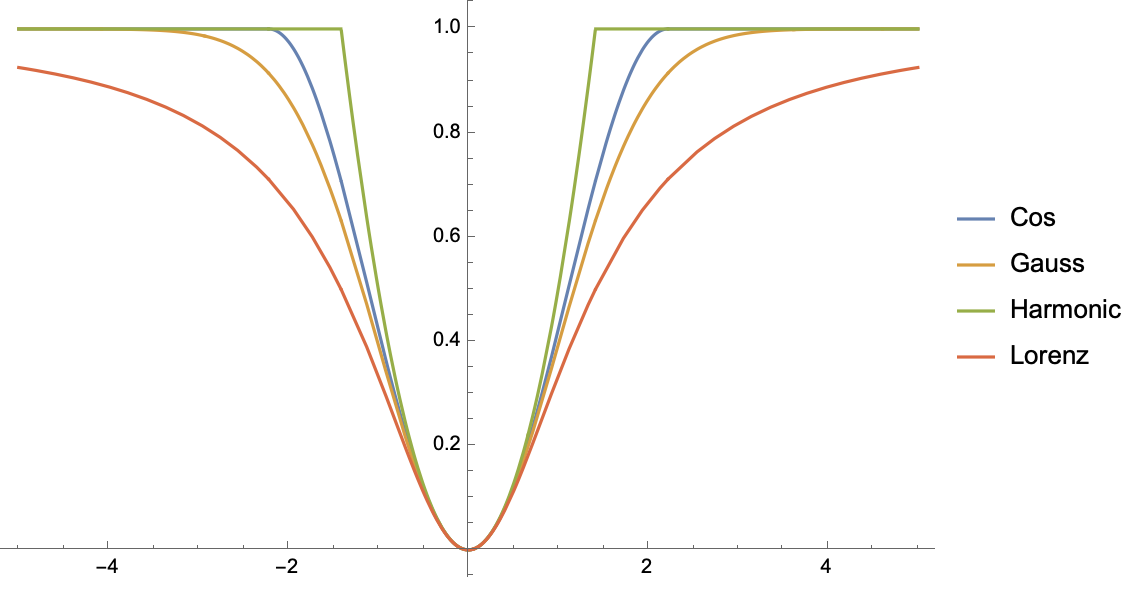

In [40]:
tspan = (0.0, 4e3);
ω_list = [0.0:0.0025:0.5;];
step = 10;

res_020 = zeros(length(ω_list));
res_025 = zeros(length(ω_list));
res_030 = zeros(length(ω_list));
res_035 = zeros(length(ω_list));
res_040 = zeros(length(ω_list));

#Messy code, I'm a bit tired :(
@showprogress for j in 1:length(ω_list)
    for i ∈ 1:step:length(samples)
        prob = ODEProblem(atom_dynamics, samples[i], tspan, [1000.0, 1.0, 3.7, ω_list[j], 0.2]);
        sol = solve(prob, dt=1.0);
        res_020[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

@showprogress for j in 1:length(ω_list)
    for i ∈ 1:step:length(samples)
        prob = ODEProblem(atom_dynamics, samples[i], tspan, [1000.0, 1.0, 3.7, ω_list[j], 0.25]);
        sol = solve(prob, dt=1.0);
        res_025[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

@showprogress for j in 1:length(ω_list)
    for i ∈ 1:step:length(samples)
        prob = ODEProblem(atom_dynamics, samples[i], tspan, [1000.0, 1.0, 3.7, ω_list[j], 0.3]);
        sol = solve(prob, dt=1.0);
        res_030[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

@showprogress for j in 1:length(ω_list)
    for i ∈ 1:step:length(samples)
        prob = ODEProblem(atom_dynamics, samples[i], tspan, [1000.0, 1.0, 3.7, ω_list[j], 0.35]);
        sol = solve(prob, dt=1.0);
        res_035[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

@showprogress for j in 1:length(ω_list)
    for i ∈ 1:step:length(samples)
        prob = ODEProblem(atom_dynamics, samples[i], tspan, [1000.0, 1.0, 3.7, ω_list[j], 0.4]);
        sol = solve(prob, dt=1.0);
        res_040[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;
            
res_020 = res_020 ./ (length(samples)/step);
res_025 = res_025 ./ (length(samples)/step);
res_030 = res_030 ./ (length(samples)/step);
res_035 = res_035 ./ (length(samples)/step);
res_040 = res_040 ./ (length(samples)/step);

Progress: 100%|█████████████████████████████████████████| Time: 2:18:35
Progress: 100%|█████████████████████████████████████████| Time: 2:16:58
Progress: 100%|█████████████████████████████████████████| Time: 2:15:12
Progress: 100%|█████████████████████████████████████████| Time: 2:12:57
Progress: 100%|█████████████████████████████████████████| Time: 5:45:35m29m


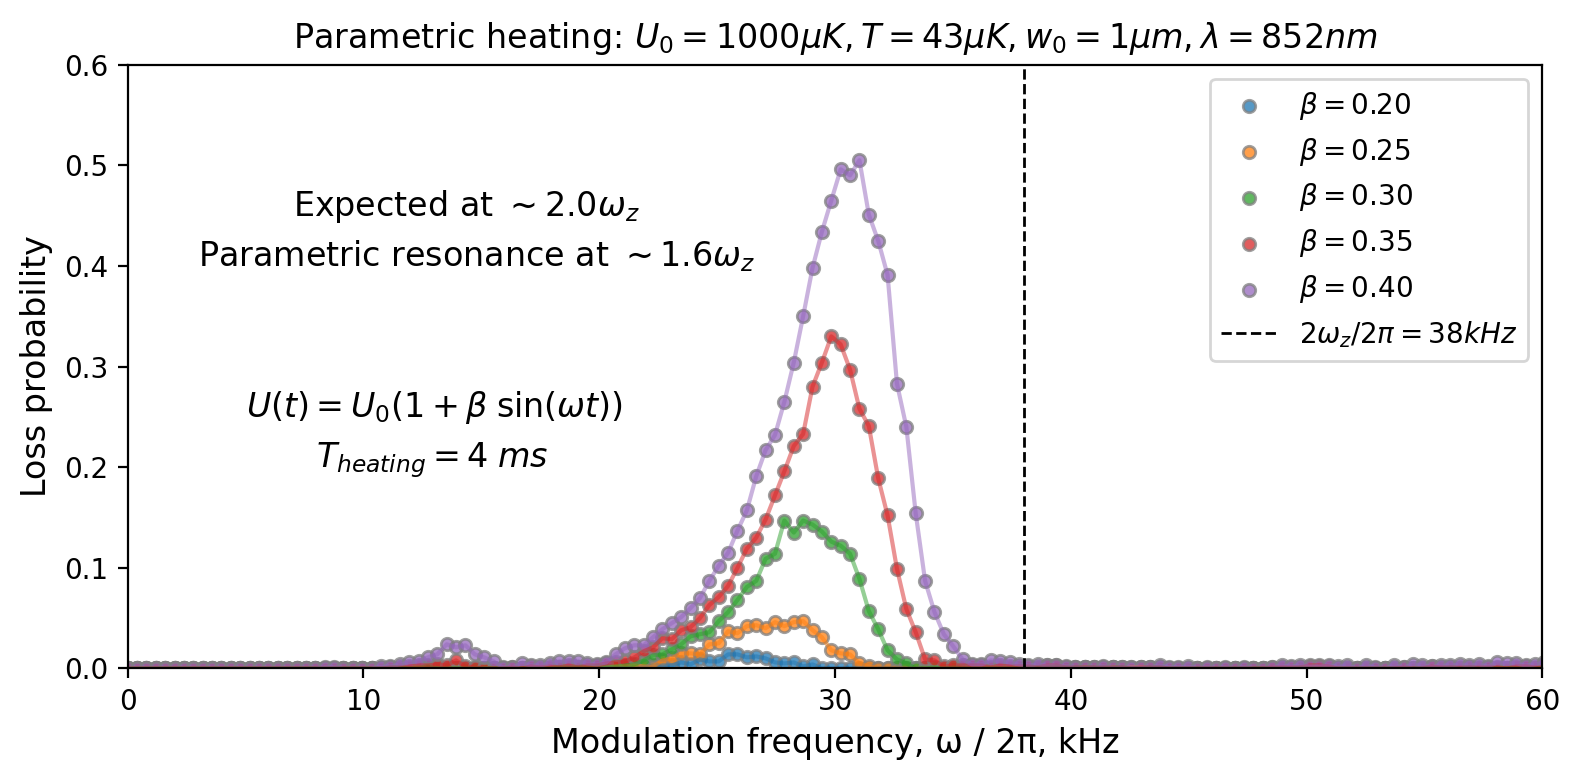

In [123]:
figure(figsize=(8,4), dpi=200)

#Another cringe
plot(ω_list * 1e3 / 2π, 1.0 .- res_020, alpha=0.5)
scatter(ω_list * 1e3 / 2π, 1.0 .- res_020,  
    s=20, 
    label="\$ \\beta = 0.20 \$", edgecolor="gray", alpha=0.75)

plot(ω_list * 1e3 / 2π, 1.0 .- res_025, alpha=0.5)
scatter(ω_list * 1e3 / 2π, 1.0 .-res_025,  
    s=20, 
    label="\$ \\beta = 0.25 \$", edgecolor="gray", alpha=0.75)

plot(ω_list * 1e3 / 2π, 1.0 .- res_030, alpha=0.5)
scatter(ω_list * 1e3 / 2π, 1.0 .- res_030,  
    s=20, 
    label="\$ \\beta = 0.30 \$", edgecolor="gray", alpha=0.75)

plot(ω_list * 1e3 / 2π, 1.0 .- res_035, alpha=0.5)
scatter(ω_list * 1e3 / 2π, 1.0 .- res_035,  
    s=20, 
    label="\$ \\beta = 0.35 \$", edgecolor="gray", alpha=0.75)

plot(ω_list * 1e3 / 2π, 1.0 .- res_040, alpha=0.5)
scatter(ω_list * 1e3 / 2π, 1.0 .- res_040,  
    s=20, 
    label="\$ \\beta = 0.40 \$", edgecolor="gray", alpha=0.75)


axvline(38.0, color="black", 
    linestyle="--", 
    linewidth=1, 
    label="\$ 2 \\omega_z / 2 \\pi = 38 kHz  \$")


xlabel("Modulation frequency, ω / 2π, kHz", fontsize=12)
ylabel("Loss probability", fontsize=12)

xlim(0.0, 60.0)
ylim(0.0,0.6)

legend()
title("Parametric heating: \$ U_0 = 1000 \\mu K, T=43 \\mu K, w_0 = 1 \\mu m ,\\lambda = 852 nm \$")
text(5, 1-0.75, "\$ U(t) = U_0 (1 + \\beta \\; \\sin(\\omega t))\$", fontsize=12)
text(8, 1-0.8, "\$ T_{heating} = 4 \\; ms\$", fontsize=12)

text(3, 1-0.6, "Parametric resonance at \$ \\sim 1.6 \\omega_z \$", fontsize=12)
text(7, 1-0.55, "Expected at \$ \\sim 2.0 \\omega_z \$", fontsize=12)

tight_layout()
savefig("data/parametric_test_many.pdf", dpi=300)

#### Radial parametric resonance

In [29]:
tspan = (0.0, 4e3);
ω_list = 2.0*π * 1e-3 * [100.0:2.0:220.0;];
step = 20;

res_020_radial = zeros(length(ω_list));

#Messy code, I'm a bit tired :(
@showprogress for j in 1:length(ω_list)
    for i ∈ 1:step:length(samples)
        prob = ODEProblem(atom_dynamics, samples[i], tspan, [1000.0, 1.0, 3.7, ω_list[j], 0.2]);
        sol = solve(prob, dt=1.0);
        res_020_radial[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

res_020_radial = res_020_radial ./ (length(samples)/step);

Progress: 100%|█████████████████████████████████████████| Time: 0:22:03


In [37]:
tspan = (0.0, 6e3);
ω_list = 2.0*π * 1e-3 * [100.0:2.0:220.0;];
step = 20;

res_010_radial = zeros(length(ω_list));

#Messy code, I'm a bit tired :(
@showprogress for j in 1:length(ω_list)
    for i ∈ 1:step:length(samples)
        prob = ODEProblem(atom_dynamics, samples[i], tspan, [1000.0, 1.0, 3.7, ω_list[j], 0.1]);
        sol = solve(prob, dt=1.0);
        res_010_radial[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

res_010_radial = res_010_radial ./ (length(samples)/step);

Progress: 100%|█████████████████████████████████████████| Time: 0:32:49


In [38]:
tspan = (0.0, 10e3);
ω_list_005 = 2.0*π * 1e-3 * [150.0:1.0:200.0;];
step = 20;

res_005_radial = zeros(length(ω_list_005));

@showprogress for j in 1:length(ω_list_005)
    for i ∈ 1:step:length(samples)
        prob = ODEProblem(atom_dynamics, samples[i], tspan, [1000.0, 1.0, 3.7, ω_list_005[j], 0.05]);
        sol = solve(prob, dt=1.0);
        res_005_radial[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

res_005_radial = res_005_radial ./ (length(samples)/step);

Progress: 100%|█████████████████████████████████████████| Time: 0:46:55


In [65]:
tspan = (0.0, 10e3);
ω_list = 2.0*π * 1e-3 * [100.0:2.0:220.0;];
step = 20;

res_010_10_radial = zeros(length(ω_list_010_50));

#Messy code, I'm a bit tired :(
@showprogress for j in 1:length(ω_list)
    for i ∈ 1:step:length(samples)
        prob = ODEProblem(atom_dynamics, samples[i], tspan, [1000.0, 1.0, 3.7, ω_list[j], 0.1]);
        sol = solve(prob, dt=1.0);
        res_010_10_radial[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

res_010_10_radial = res_010_10_radial ./ (length(samples)/step);

Progress: 100%|█████████████████████████████████████████| Time: 0:54:48


In [72]:
tspan = (0.0, 50e3);
ω_list_010_50_radial = 2.0*π * 1e-3 * [165.0:2.0:175.0;];
step = 20;

res_010_50_radial = zeros(length(ω_list));

#Messy code, I'm a bit tired :(
@showprogress for j in 1:length(ω_list_010_50_radial)
    @showprogress for i ∈ 1:step:length(samples)
        prob = ODEProblem(atom_dynamics, samples[i], tspan, [1000.0, 1.0, 3.7, ω_list_010_50_radial[j], 0.1]);
        sol = solve(prob, dt=1.0);
        res_010_50_radial[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

res_010_50_radial = res_010_50_radial ./ (length(samples)/step);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:23
Progress: 100%|█████████████████████████████████████████| Time: 0:04:16
Progress: 100%|█████████████████████████████████████████| Time: 0:04:16
Progress: 100%|█████████████████████████████████████████| Time: 0:04:18
Progress: 100%|█████████████████████████████████████████| Time: 0:04:11
Progress: 100%|█████████████████████████████████████████| Time: 0:04:13
Progress: 100%|█████████████████████████████████████████| Time: 0:25:39


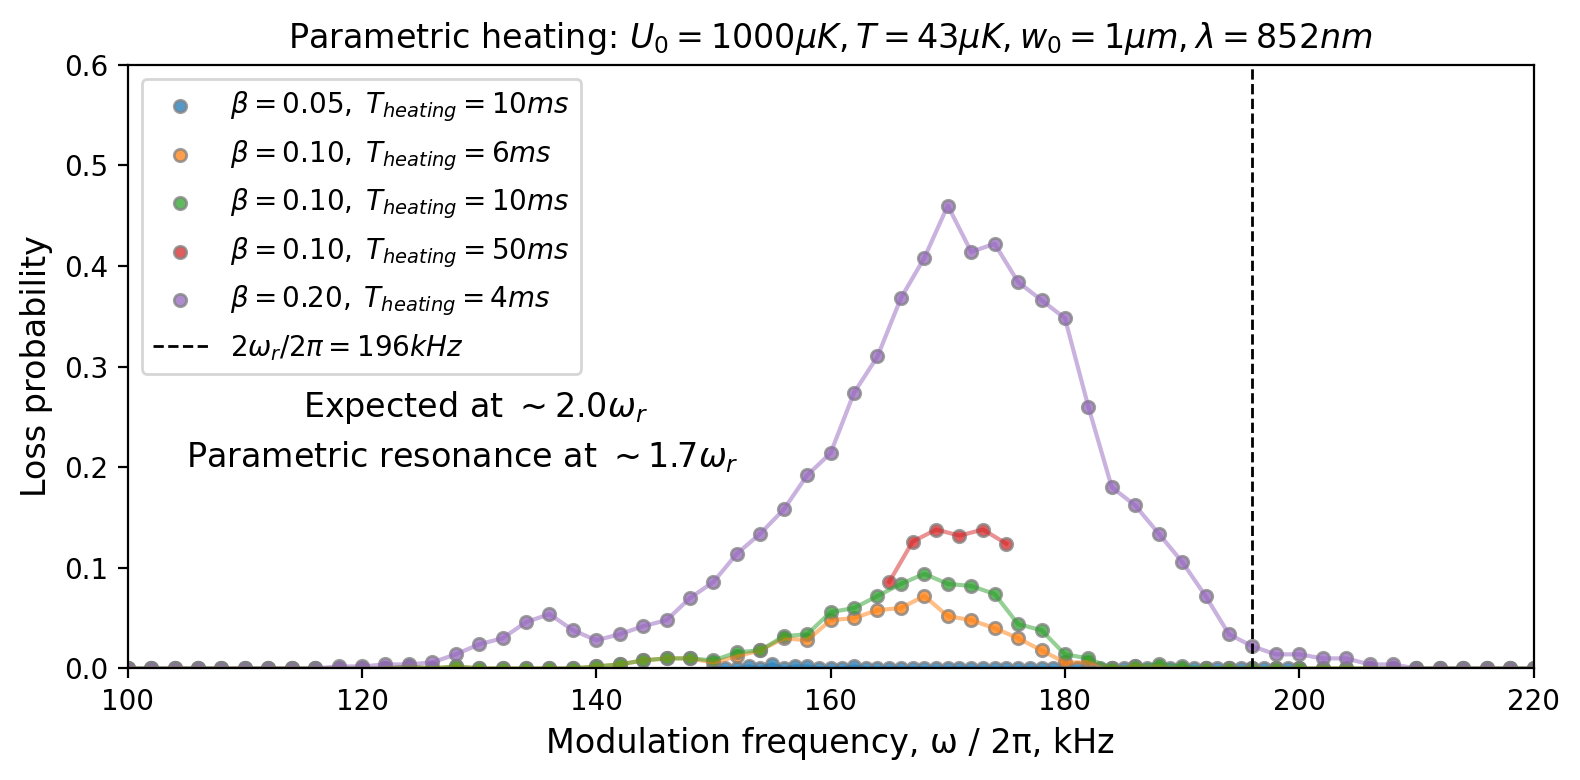

In [92]:
figure(figsize=(8,4), dpi=200)
plot(ω_list_005 * 1e3 / 2π, 1.0 .- res_005_radial, alpha=0.5)
scatter(ω_list_005 * 1e3 / 2π, 1.0 .- res_005_radial,  
    s=20, 
    label="\$ \\beta = 0.05,\\;  T_{heating} = 10 ms \$", edgecolor="gray", alpha=0.75)


plot(ω_list * 1e3 / 2π, 1.0 .- res_010_radial, alpha=0.5)
scatter(ω_list * 1e3 / 2π, 1.0 .- res_010_radial,  
    s=20, 
    label="\$ \\beta = 0.10,\\; T_{heating} = 6 ms\$", edgecolor="gray", alpha=0.75)

plot(ω_list * 1e3 / 2π, 1.0 .- res_010_10_radial, alpha=0.5)
scatter(ω_list * 1e3 / 2π, 1.0 .- res_010_10_radial,  
    s=20, 
    label="\$ \\beta = 0.10,\\; T_{heating} = 10 ms\$", edgecolor="gray", alpha=0.75)

plot(ω_list_010_50_radial * 1e3 / 2π, 1.0 .- res_010_50_radial, alpha=0.5)
scatter(ω_list_010_50_radial * 1e3 / 2π, 1.0 .- res_010_50_radial,  
    s=20, 
    label="\$ \\beta = 0.10,\\; T_{heating} = 50 ms\$", edgecolor="gray", alpha=0.75)


plot(ω_list * 1e3 / 2π, 1.0 .- res_020_radial, alpha=0.5)
scatter(ω_list * 1e3 / 2π, 1.0 .- res_020_radial,  
    s=20, 
    label="\$ \\beta = 0.20,\\;  T_{heating} = 4 ms \$", edgecolor="gray", alpha=0.75)



axvline(2*98.0, color="black", 
    linestyle="--", 
    linewidth=1, 
    label="\$ 2 \\omega_r / 2 \\pi = 196 kHz  \$")

xlabel("Modulation frequency, ω / 2π, kHz", fontsize=12)
ylabel("Loss probability", fontsize=12)

xlim(100.0, 220.0)
ylim(0.0,0.6)

text(105, 0.2, "Parametric resonance at \$ \\sim 1.7 \\omega_r \$", fontsize=12)
text(115, 0.25, "Expected at \$ \\sim 2.0 \\omega_r \$", fontsize=12)
title("Parametric heating: \$ U_0 = 1000 \\mu K, T=43 \\mu K, w_0 = 1 \\mu m ,\\lambda = 852 nm \$")

legend()
tight_layout()
savefig("data/parametric_test_many_radial.pdf", dpi=300)

_Longitudinal parametric resonance_

- $2 \times 19$ kHz - expected

- $2 \times 15$ kHz - computed


_Radial parametric resonance_

- $2 \times 98$ kHz - expected

- $2 \times 85$ kHz - computed

__Results:__

- Parametric resonances at $1.6 \omega_z$, $1.7 \omega_r$

### Switching trap on and off with variable $\Delta t$


- https://arxiv.org/pdf/physics/0003075.pdf

<img src="images/trap_on_off.jpeg" 
     align="left" 
     width="1000" />

In [185]:
function time_profile(t, t1, t2, Δt)
    return t < t1 || (t > t1+Δt && t < t1+Δt+t2) ? 0.0 : 1.0
end;

In [186]:
time_profile(20, 4, 12, 1)

1.0

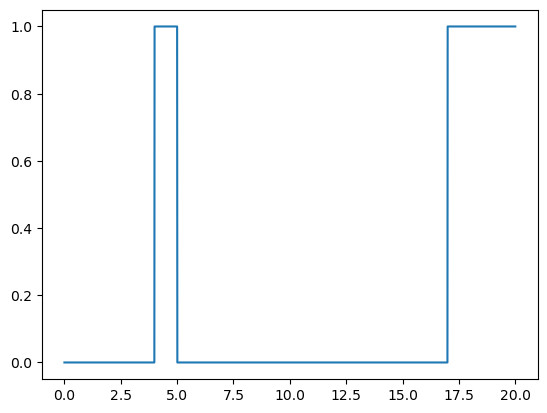

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x11ef90df0>

In [187]:
tspan = [0.0:0.01:20.0;];
t1 = 4.0;
t2 = 12.0;
plot(tspan, time_profile.(tspan, t1, t2, 1))

In [274]:
function atom_dynamics_Beguin(du, u, params, t)
    U0, w0, z0, t1, t2, Δt,  = params;
    x, y, z = u[1], u[2], u[3];
    vx, vy, vz = u[4], u[5], u[6];
    
    du[1], du[2], du[3] = vx, vy, vz;
    du[4] =  time_profile(t, t1, t2, Δt) * f(x, y, z, params) * x;
    du[5] =  time_profile(t, t1, t2, Δt) * f(x, y, z, params) * y;
    du[6] =  time_profile(t, t1, t2, Δt) * f(x, y, z, params) * (w0^2/(2.0 * z0^2) .- (x .^2 + y .^2)./(z .^2 .+ z0^2)) * z; 
end;

In [192]:
t1 = 4.0;
t2 = 12.0;

Δt_list = [0.0:0.25:25.0;];
sample_step = 25;

res_onoff = zeros(length(Δt_list));

@showprogress for j in 1:length(Δt_list)
    for i ∈ 1:sample_step:length(samples)
        tspan = (0.0, t1+t2+Δt_list[j]);
        prob = ODEProblem(atom_dynamics_Beguin, samples[i], tspan, [1000.0, 1.0, 3.7, t1, t2, Δt_list[j]]);
        sol = solve(prob, dt=1.0);
        res_onoff[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

res_onoff = res_onoff ./ (length(samples)/sample_step);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


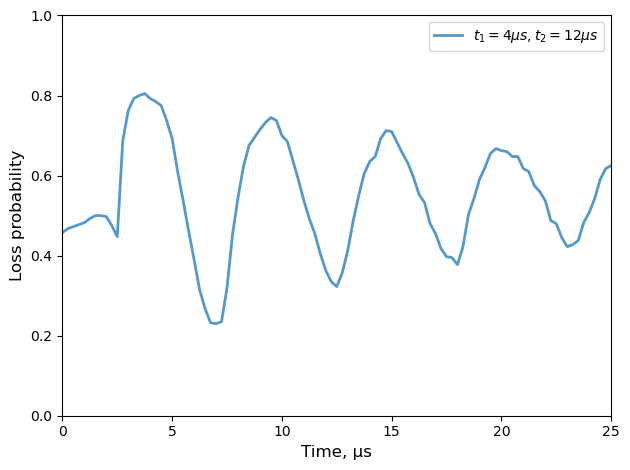

In [193]:
plot(Δt_list, 1.0 .- res_onoff, alpha=0.75, linewidth=2, label="\$ t_1 = 4\\mu s, t_2 = 12\\mu s\$")
xlabel("Time, μs", fontsize=12)
ylabel("Loss probability", fontsize=12)

xlim(0.0, 25.0)
ylim(0.0, 1.0)
legend()
tight_layout()

In [240]:
println(Δt_list[idx][1:end])
println(Δt_list[idx][3:end])
println(Δt_list[idx][1:end-2])

println(Δt_list[idx][2:end] - Δt_list[idx][1:end-1])
println(mean(Δt_list[idx][3:end] - Δt_list[idx][2:end-1]))
println(mean(Δt_list[idx][2:end] - Δt_list[idx][1:end-1]))

[3.7, 7.1, 9.5, 12.5, 15.0, 17.8, 20.4, 23.1]
[9.5, 12.5, 15.0, 17.8, 20.4, 23.1]
[3.7, 7.1, 9.5, 12.5, 15.0, 17.8]
[3.3999999999999995, 2.4000000000000004, 3.0, 2.5, 2.8000000000000007, 2.599999999999998, 2.700000000000003]
2.6666666666666665
2.771428571428572


In [244]:
period1 = 2*mean(Δt_list[idx][3:end] - Δt_list[idx][2:end-1]);
period2 = 2*mean(Δt_list[idx][2:end] - Δt_list[idx][1:end-1]);
period3 = 2*mean(Δt_list[idx][4:end] - Δt_list[idx][3:end-1]);

println(1/period1 * 1e3)
println(1/period2 * 1e3)
println(1/period3 * 1e3)

187.5
180.4123711340206
183.8235294117647


#### On-off measurements for different $t_1, t_2$

In [207]:
Δt_list = [0.0:0.25:25.0;];
sample_step = 25;

#res_onoff_t1_t2
res_onoff_4_0 = zeros(length(Δt_list));
res_onoff_4_4 = zeros(length(Δt_list));
res_onoff_4_8 = zeros(length(Δt_list));
res_onoff_4_16 = zeros(length(Δt_list));

@showprogress for j in 1:length(Δt_list)
    for i ∈ 1:sample_step:length(samples)
        tspan = (0.0, 4+4+Δt_list[j]);
        prob = ODEProblem(atom_dynamics_Beguin, samples[i], tspan, [1000.0, 1.0, 3.7, 4, 0, Δt_list[j]]);
        sol = solve(prob, dt=1.0);
        res_onoff_4_0[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

@showprogress for j in 1:length(Δt_list)
    for i ∈ 1:sample_step:length(samples)
        tspan = (0.0, 4+4+Δt_list[j]);
        prob = ODEProblem(atom_dynamics_Beguin, samples[i], tspan, [1000.0, 1.0, 3.7, 4, 4, Δt_list[j]]);
        sol = solve(prob, dt=1.0);
        res_onoff_4_4[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

@showprogress for j in 1:length(Δt_list)
    for i ∈ 1:sample_step:length(samples)
        tspan = (0.0, 4+8+Δt_list[j]);
        prob = ODEProblem(atom_dynamics_Beguin, samples[i], tspan, [1000.0, 1.0, 3.7, 4, 8, Δt_list[j]]);
        sol = solve(prob, dt=1.0);
        res_onoff_4_8[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

@showprogress for j in 1:length(Δt_list)
    for i ∈ 1:sample_step:length(samples)
        tspan = (0.0, 4+16+Δt_list[j]);
        prob = ODEProblem(atom_dynamics_Beguin, samples[i], tspan, [1000.0, 1.0, 3.7, 4, 16, Δt_list[j]]);
        sol = solve(prob, dt=1.0);
        res_onoff_4_16[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

res_onoff_4_0 = res_onoff_4_0 ./ (length(samples)/sample_step);
res_onoff_4_4 = res_onoff_4_4 ./ (length(samples)/sample_step);
res_onoff_4_8 = res_onoff_4_8 ./ (length(samples)/sample_step);
res_onoff_4_16 = res_onoff_4_16 ./ (length(samples)/sample_step);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


In [205]:
Δt_list = [0.0:0.25:25.0;];
sample_step = 25;

#res_onoff_t1_t2
res_onoff_0_8 = zeros(length(Δt_list));
res_onoff_4_8 = zeros(length(Δt_list));
res_onoff_8_8 = zeros(length(Δt_list));
res_onoff_16_8 = zeros(length(Δt_list));

@showprogress for j in 1:length(Δt_list)
    for i ∈ 1:sample_step:length(samples)
        tspan = (0.0, 0+8+Δt_list[j]);
        prob = ODEProblem(atom_dynamics_Beguin, samples[i], tspan, [1000.0, 1.0, 3.7, 0, 8, Δt_list[j]]);
        sol = solve(prob, dt=1.0);
        res_onoff_0_8[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

@showprogress for j in 1:length(Δt_list)
    for i ∈ 1:sample_step:length(samples)
        tspan = (0.0, 4+8+Δt_list[j]);
        prob = ODEProblem(atom_dynamics_Beguin, samples[i], tspan, [1000.0, 1.0, 3.7, 4, 8, Δt_list[j]]);
        sol = solve(prob, dt=1.0);
        res_onoff_4_8[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

@showprogress for j in 1:length(Δt_list)
    for i ∈ 1:sample_step:length(samples)
        tspan = (0.0, 8+8+Δt_list[j]);
        prob = ODEProblem(atom_dynamics_Beguin, samples[i], tspan, [1000.0, 1.0, 3.7, 8, 8, Δt_list[j]]);
        sol = solve(prob, dt=1.0);
        res_onoff_8_8[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

@showprogress for j in 1:length(Δt_list)
    for i ∈ 1:sample_step:length(samples)
        tspan = (0.0, 8+16+Δt_list[j]);
        prob = ODEProblem(atom_dynamics_Beguin, samples[i], tspan, [1000.0, 1.0, 3.7, 16, 8, Δt_list[j]]);
        sol = solve(prob, dt=1.0);
        res_onoff_16_8[j] += H(sol[end], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

res_onoff_0_8 = res_onoff_0_8 ./ (length(samples)/sample_step);
res_onoff_4_8 = res_onoff_4_8 ./ (length(samples)/sample_step);
res_onoff_8_8 = res_onoff_8_8 ./ (length(samples)/sample_step);
res_onoff_16_8 = res_onoff_16_8 ./ (length(samples)/sample_step);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


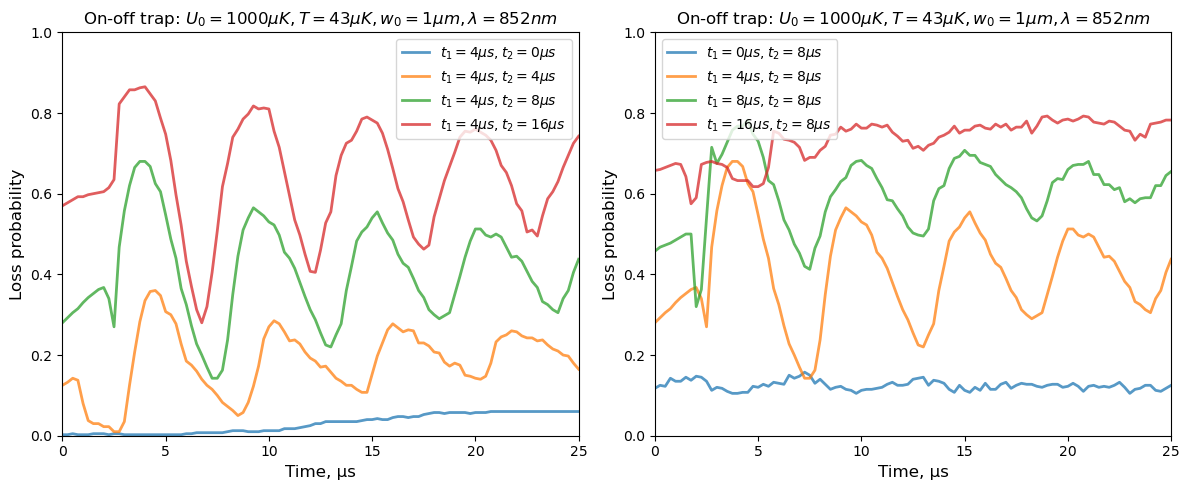

In [209]:
figure(figsize=(12,5))
subplot(121)
plot(Δt_list, 1.0 .- res_onoff_4_0, alpha=0.75, linewidth=2, label="\$ t_1 = 4\\mu s, t_2 = 0\\mu s\$")
plot(Δt_list, 1.0 .- res_onoff_4_4, alpha=0.75, linewidth=2, label="\$ t_1 = 4\\mu s, t_2 = 4\\mu s\$")
plot(Δt_list, 1.0 .- res_onoff_4_8, alpha=0.75, linewidth=2, label="\$ t_1 = 4\\mu s, t_2 = 8\\mu s\$")
plot(Δt_list, 1.0 .- res_onoff_4_16, alpha=0.75, linewidth=2, label="\$ t_1 = 4\\mu s, t_2 = 16\\mu s\$")

xlabel("Time, μs", fontsize=12)
ylabel("Loss probability", fontsize=12)
xlim(0.0, 25.0)
ylim(0.0, 1.0)
legend()
title("On-off trap: \$ U_0 = 1000 \\mu K, T=43 \\mu K, w_0 = 1 \\mu m ,\\lambda = 852 nm \$")

subplot(122)
plot(Δt_list, 1.0 .- res_onoff_0_8, alpha=0.75, linewidth=2, label="\$ t_1 = 0\\mu s, t_2 = 8\\mu s\$")
plot(Δt_list, 1.0 .- res_onoff_4_8, alpha=0.75, linewidth=2, label="\$ t_1 = 4\\mu s, t_2 = 8\\mu s\$")
plot(Δt_list, 1.0 .- res_onoff_8_8, alpha=0.75, linewidth=2, label="\$ t_1 = 8\\mu s, t_2 = 8\\mu s\$")
plot(Δt_list, 1.0 .- res_onoff_16_8, alpha=0.75, linewidth=2, label="\$ t_1 = 16\\mu s, t_2 = 8\\mu s\$")

xlabel("Time, μs", fontsize=12)
ylabel("Loss probability", fontsize=12)
xlim(0.0, 25.0)
ylim(0.0, 1.0)
legend()
title("On-off trap: \$ U_0 = 1000 \\mu K, T=43 \\mu K, w_0 = 1 \\mu m ,\\lambda = 852 nm \$")

tight_layout()
savefig("data/onoff_trap_many.pdf", dpi=200)

__1D case__

__Rate of parametric heating in 3D.__

In harmonic approximation heating is exponential. What happens with exact solution?

In [ ]:
tspan = (0.0, 2e3);

ω_list = [0.0:0.005:0.4;];
res_energy = zeros(length(ω_list));
step = 10;


@showprogress for i ∈ 1:step:length(samples)
    prob = ODEProblem(atom_dynamics, samples[i], tspan, [1000.0, 1.0, 3.7, 2\pi * 30.0 * 1e-3, 0.4]);
    sol = solve(prob,dt=10.0);
    res_energy[j] += H(sol[end], [1000.0, 1.0, 3.7], m);
end;


res_adaptive = res_adaptive ./ (length(samples)/step);

In [340]:
prob = ODEProblem(atom_dynamics, samples[100], tspan, [1000.0, 1.0, 3.7, 2π * 30.0 * 1e-3, 0.4]);
sol = solve(prob, dt=1.0);

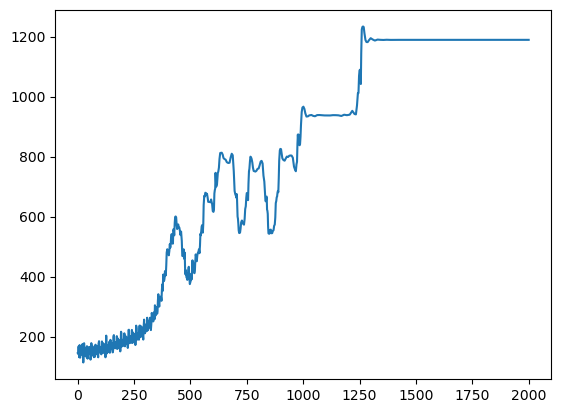

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1b329e7d0>

In [350]:
sol_H = [];

for k in 1:length(sol.t)
    append!(sol_H, H(sol[k], [1000.0, 1.0, 3.7], m));
end;

plot(sol.t, sol_H)

### Parametric excitation in 1D

In [162]:
function atom_dynamics_1D_z(du, u, params, t)
    U0, w0, z0, ω, β = params;
    z = u[1];
    vz = u[2];

    du[1] = vz;
    du[2] = -(1.0 .+ β * sin.(ω * t)) * 2.0 * U0/m * vconst^2 * z ./ ((1.0 .+ (z ./ z0) .^2) * z0^2);
end;

function atom_dynamics_1D_r(du, u, params, t)
    U0, w0, z0, ω, β = params;
    r = u[1];
    vr = u[2];

    du[1] = vr;
    du[2] = -(1.0 .+ β * sin.(ω * t)) * 4.0 * U0/m * exp.(-2*r .^2 ./ w0^2) * vconst^2 * r ./ w0^2;
end;

In [166]:
tspan = (0.0, 10e3);

ω_list = [0.0:0.01:1.5;];
res_1D_z = zeros(length(ω_list));
res_1D_r = zeros(length(ω_list));
step = 100;

@showprogress for j in 1:length(ω_list)
    for i ∈ 1:step:length(samples)
        prob_z = ODEProblem(atom_dynamics_1D_z, [samples[i][3], samples[i][6]], tspan, [1000.0, 1.0, 3.7, ω_list[j], 0.4]);
        sol_z = solve(prob_z, dt=1.0);
        res_1D_z[j] += H([0.0, 0.0, sol_z[end][1], 0.0, 0.0, sol_z[end][2]], [1000.0, 1.0, 3.7], m) < 1000.0;
        
        prob_r = ODEProblem(atom_dynamics_1D_r, [samples[i][1], samples[i][4]], tspan, [1000.0, 1.0, 3.7, ω_list[j], 0.4]);
        sol_r = solve(prob_r, dt=1.0);
        res_1D_r[j] += H([sol_r[end][1], 0.0, 0.0, sol_r[end][2], 0.0, 0.0], [1000.0, 1.0, 3.7], m) < 1000.0;
    end;
end;

res_1D_z = res_1D_z ./ (length(samples)/step);
res_1D_r = res_1D_r ./ (length(samples)/step);

Progress: 100%|█████████████████████████████████████████| Time: 0:13:49


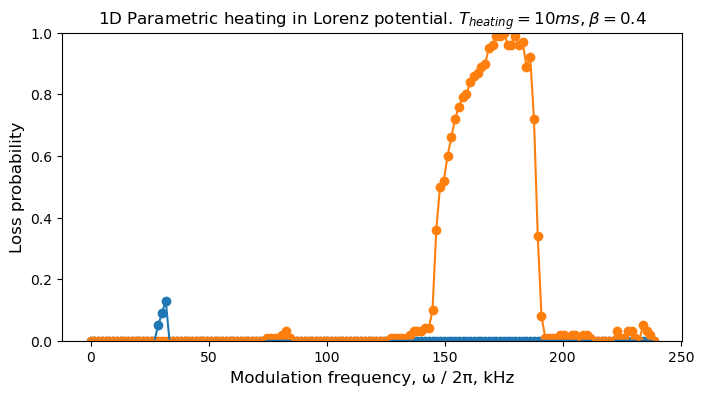

PyObject Text(0.5, 1.0, '1D Parametric heating in Lorenz potential. $T_{heating}=10ms, \\beta = 0.4$')

In [167]:
figure(figsize=(8,4))
plot(ω_list * 1e3 / 2π, 1 .-res_1D_z)
scatter(ω_list * 1e3 / 2π, 1 .-res_1D_z, label="Longitudinal")

plot(ω_list * 1e3 / 2π, 1 .-res_1D_r)
scatter(ω_list * 1e3 / 2π, 1 .-res_1D_r, label="Longitudinal")

xlabel("Modulation frequency, ω / 2π, kHz", fontsize=12)
ylabel("Loss probability", fontsize=12)
ylim(0.0, 1.0)

title("1D Parametric heating in Lorenz potential. \$T_{heating}=10ms, \\beta = 0.4\$")

Heating in 1D Lorenz trap is significantly slower than in 1D Gaussian 

In [6]:
using CSV
using DataFrames

In [85]:
filename = "data/2023_10_30_RESONANCE_SCAN.dat";


LoadError: ArgumentError: provide a valid sink argument, like `using DataFrames; CSV.read(source, DataFrame)`

In [158]:
header = 18;

x = [];
y = [];

open(filename) do file
    i = 1;
    for line in eachline(file)
        if i >= header
            append!(x, parse(Float64, line[5:12]));
            append!(y, parse(Float64, line[21:25]));
        end;
        i += 1;
    end;
end;

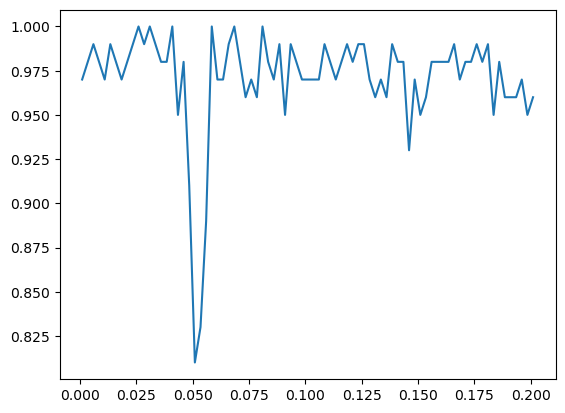

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x11e7564a0>

In [159]:
plot(x, y)

In [160]:
0.05 * 1e3

50.0

In [161]:
50, 140

(50, 140)

### Adiabatic trap lowering 

<img src="images/adiabatic.png" 
     align="left" 
     width="800" />

In [516]:
function trap_lowering(t, U0, U1, t1)
    return (U1 - U0)/t1 * t .+ U0;
end;

In [536]:
function atom_dynamics_adiabatic(du, u, params, t)
    U0, w0, z0, U1, t1 = params;
    x, y, z = u[1], u[2], u[3];
    vx, vy, vz = u[4], u[5], u[6];
    
    du[1], du[2], du[3] = vx, vy, vz;
    du[4] =  trap_lowering(t, U0, U1, t1) * f(x, y, z, [1.0, w0, z0]) * x;
    du[5] =  trap_lowering(t, U0, U1, t1) * f(x, y, z, [1.0, w0, z0]) * y;
    du[6] =  trap_lowering(t, U0, U1, t1) * f(x, y, z, [1.0, w0, z0]) * (w0^2/(2.0 * z0^2) .- (x .^2 + y .^2)./(z .^2 .+ z0^2)) * z; 
end;

In [611]:
U1_list = 10.0 .^ ([-2.0:0.1:3.0;]);
sample_step = 10;
#If you change U0, w0 or z0 you need to resample atoms in MCMC
U0 = 1000.0;


res_10 = zeros(length(U1_list));
res_25 = zeros(length(U1_list));
res_50 = zeros(length(U1_list));
res_100 = zeros(length(U1_list));
res_250 = zeros(length(U1_list));

t1 = 10.0;
tspan = (0.0, t1);
@showprogress for j in 1:length(U1_list)
    for i ∈ 1:sample_step:length(samples)
        prob = ODEProblem(atom_dynamics_adiabatic, samples[i], tspan, [U0, 1.0, 3.7, U1_list[j], t1]);
        sol = solve(prob; dt=0.001);
        res_10[j] += H(sol[end], [U1_list[j], 1.0, 3.7], m) < U1_list[j];
    end;
end;

t1 = 25.0;
tspan = (0.0, t1);
@showprogress for j in 1:length(U1_list)
    for i ∈ 1:sample_step:length(samples)
        prob = ODEProblem(atom_dynamics_adiabatic, samples[i], tspan, [U0, 1.0, 3.7, U1_list[j], t1]);
        sol = solve(prob; dt=0.001);
        res_25[j] += H(sol[end], [U1_list[j], 1.0, 3.7], m) < U1_list[j];
    end;
end;

t1 = 50.0;
tspan = (0.0, t1);
@showprogress for j in 1:length(U1_list)
    for i ∈ 1:sample_step:length(samples)
        prob = ODEProblem(atom_dynamics_adiabatic, samples[i], tspan, [U0, 1.0, 3.7, U1_list[j], t1]);
        sol = solve(prob; dt=0.001);
        res_50[j] += H(sol[end], [U1_list[j], 1.0, 3.7], m) < U1_list[j];
    end;
end;

t1 = 100.0;
tspan = (0.0, t1);
@showprogress for j in 1:length(U1_list)
    for i ∈ 1:sample_step:length(samples)
        prob = ODEProblem(atom_dynamics_adiabatic, samples[i], tspan, [U0, 1.0, 3.7, U1_list[j], t1]);
        sol = solve(prob; dt=0.001);
        res_100[j] += H(sol[end], [U1_list[j], 1.0, 3.7], m) < U1_list[j];
    end;
end;

t1 = 250.0;
tspan = (0.0, t1);
@showprogress for j in 1:length(U1_list)
    for i ∈ 1:sample_step:length(samples)
        prob = ODEProblem(atom_dynamics_adiabatic, samples[i], tspan, [U0, 1.0, 3.7, U1_list[j], t1]);
        sol = solve(prob; dt=0.001);
        res_250[j] += H(sol[end], [U1_list[j], 1.0, 3.7], m) < U1_list[j];
    end;
end;

res_10 = res_10 ./ (length(samples)/sample_step);
res_25 = res_25 ./ (length(samples)/sample_step);
res_50 = res_50 ./ (length(samples)/sample_step);
res_100 = res_100 ./ (length(samples)/sample_step);
res_250 = res_250 ./ (length(samples)/sample_step);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07
Progress: 100%|█████████████████████████████████████████| Time: 0:02:10


In [613]:
function nice_plot(x, y, label)
    plot(x, y, alpha=0.75, linewidth=2)
    scatter(x, y,
        alpha=0.75, 
        edgecolors="grey", 
        s=50,
        zorder=2,
        label=label)
end;

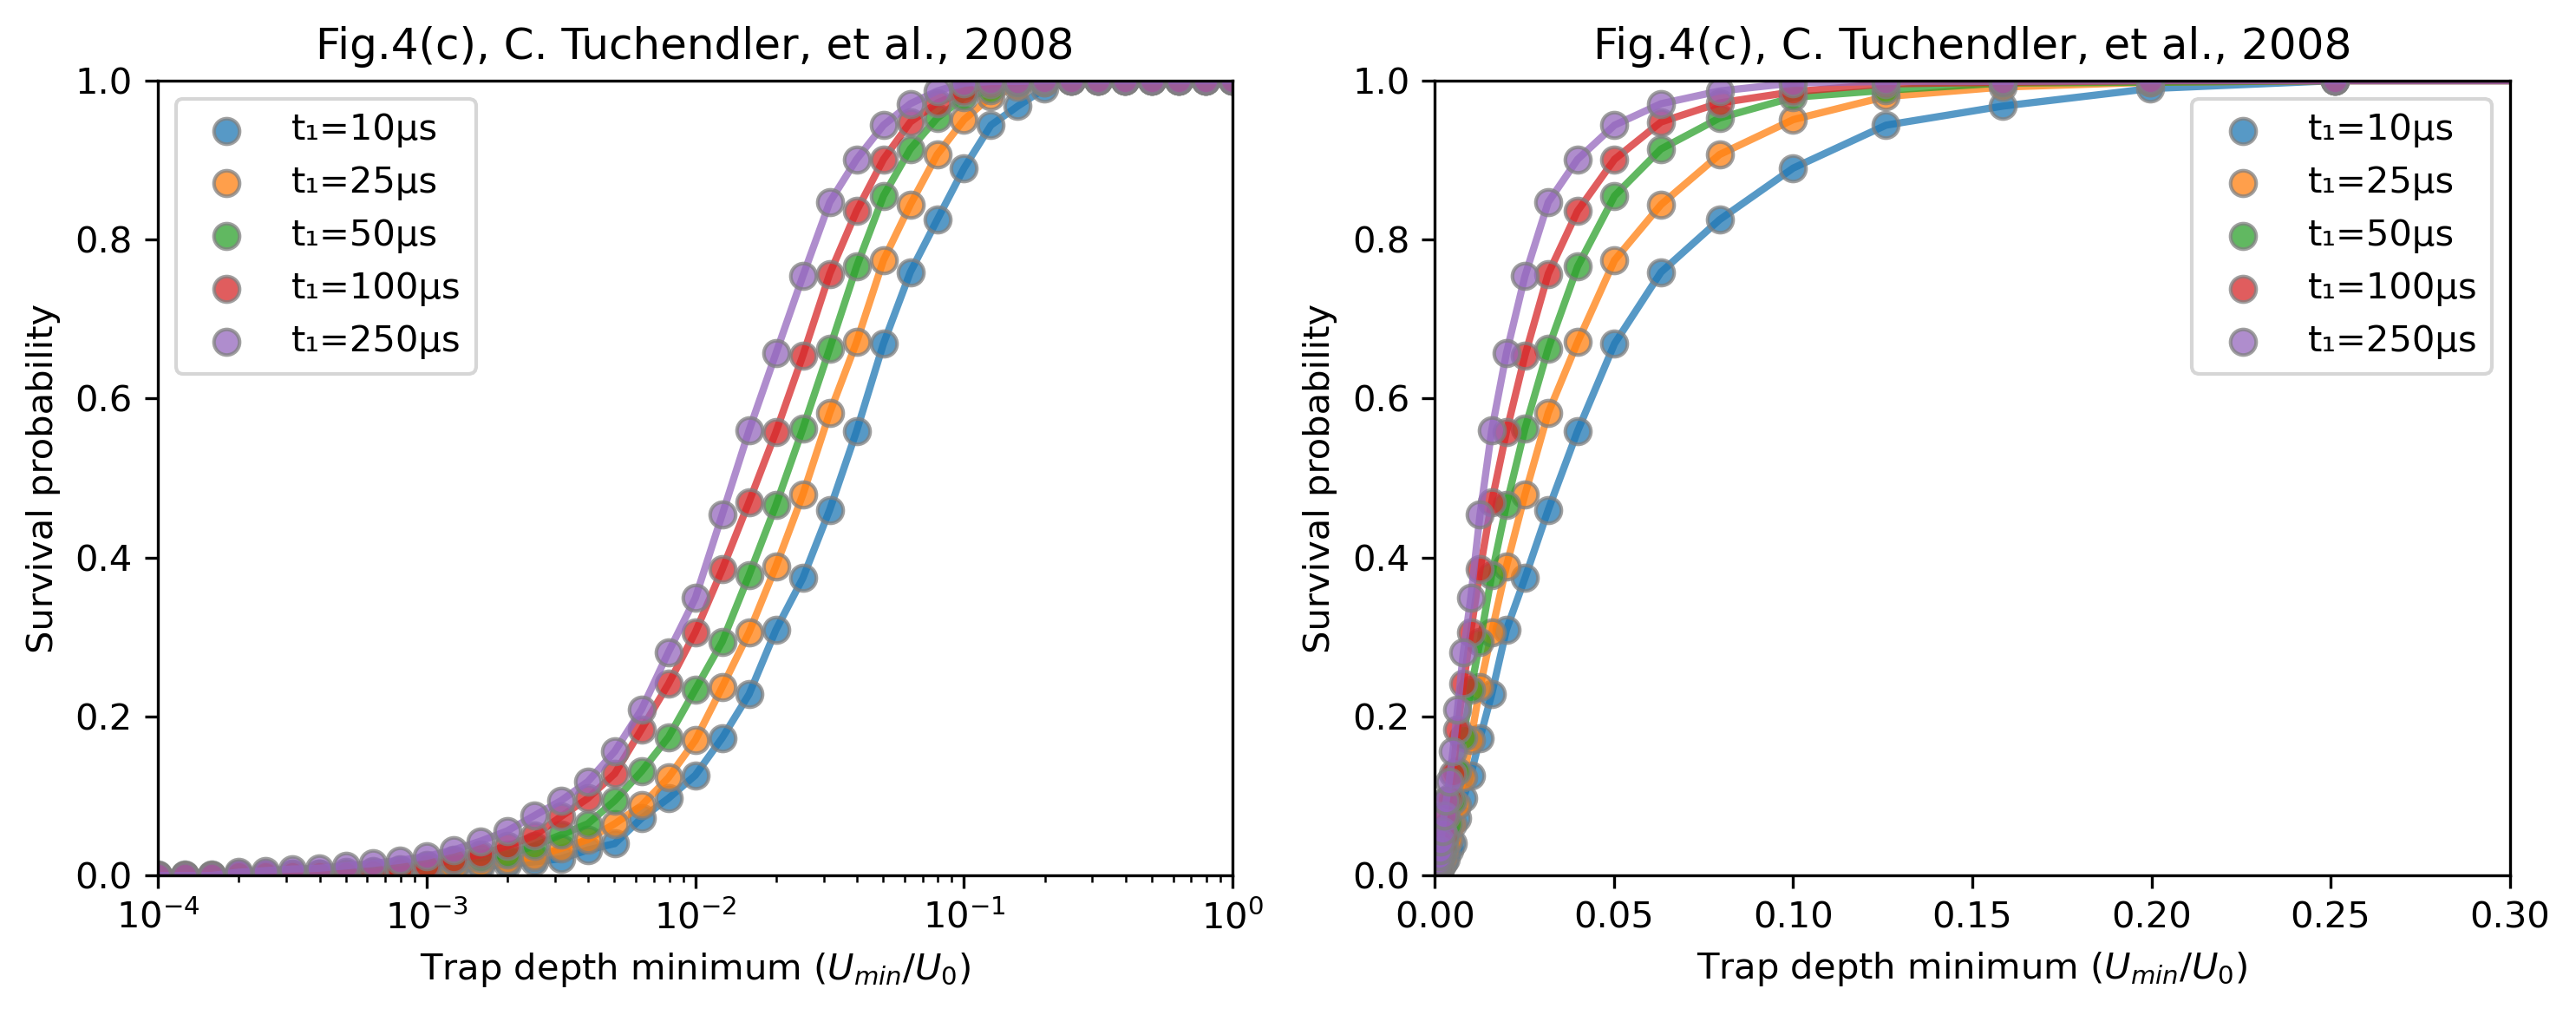

In [633]:
figure(figsize=(10,4), dpi=300)

subplot(121)
nice_plot(U1_list ./ U0, res_10, "t₁=10μs")
nice_plot(U1_list ./ U0, res_25, "t₁=25μs")
nice_plot(U1_list ./ U0, res_50, "t₁=50μs")
nice_plot(U1_list ./ U0, res_100, "t₁=100μs")
nice_plot(U1_list ./ U0, res_250, "t₁=250μs")


xlabel("Trap depth minimum \$ (U_{min}/U_0) \$")
ylabel("Survival probability")
legend()
xscale("log")
xlim(10 ^(-4), 1.0)
ylim(0.0, 1.0)
title("Fig.4(c), C. Tuchendler, et al., 2008")



subplot(122)
nice_plot(U1_list ./ U0, res_10, "t₁=10μs")
nice_plot(U1_list ./ U0, res_25, "t₁=25μs")
nice_plot(U1_list ./ U0, res_50, "t₁=50μs")
nice_plot(U1_list ./ U0, res_100, "t₁=100μs")
nice_plot(U1_list ./ U0, res_250, "t₁=250μs")


xlabel("Trap depth minimum \$ (U_{min}/U_0) \$")
ylabel("Survival probability")
legend()
xlim(0.0, 0.3)
ylim(0.0, 1.0)
title("Fig.4(c), C. Tuchendler, et al., 2008")



tight_layout()

savefig("data/trap_lowering_fig4.pdf", dpi=300)

## Trap depth through AC Stark shifts